In [1]:
%load_ext jupyter_black

# fitting probsevere data into a grid

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

PARQUET_FILE = "/workspaces/griblib/data/2022-07.parquet"
MIN_PROBSEVERE = 20

idx: slice = pd.IndexSlice

- open the previously created parquet
- select only storms that had a probsevere value of gt 20 durring their life cycle

In [3]:
df: gpd.GeoDataFrame = gpd.read_parquet(PARQUET_FILE)
# bool values of where the max PS for a storm was less that 20
mask = df["PS"].groupby("ID").max() > MIN_PROBSEVERE
# index the dataframe with the storm id's where ps > 20
df = df.loc[idx[:, mask[mask].index], :]
df

,,geometry,MUCAPE,MLCAPE,MLCIN,EBSHEAR,SRH01KM,MEANWIND_1-3kmAGL,MESH,VIL_DENSITY,FLASH_RATE,...,MAXRC_ICECF,WETBULB_0C_HGT,PWAT,CAPE_M10M30,LJA,SIZE,AVG_BEAM_HGT,MOTION_EAST,MOTION_SOUTH,PS
validTime,ID,,,,,,,,,,,,,,,,,,,,,
2022-07-20 01:04:40,355308,"POLYGON ((-81.82000 33.65000, -81.77000 33.650...",1818.0,1438.0,-12.0,16.900000,73.0,17.900000,0.77,2.34,40.0,...,0026Z 0.0/min (weak),13.1,2.1,430.0,0.0,434.0,3.41 kft / 1.04 km,5.333,-0.627,19.0
2022-07-20 00:14:40,355308,"POLYGON ((-82.44000 33.68000, -82.41000 33.680...",1784.0,1428.0,-14.0,15.100000,60.0,18.600000,0.59,3.03,36.0,...,2326Z 0.0/min (weak),13.0,2.2,437.0,0.0,546.0,6.32 kft / 1.93 km,3.386,0.849,9.0
2022-07-20 00:40:40,355308,"POLYGON ((-82.07000 33.72000, -82.03000 33.700...",1683.0,1394.0,-17.0,15.400000,66.0,17.799999,0.74,2.71,32.0,...,0026Z 0.0/min (weak),13.1,2.1,424.0,0.8,200.0,4.60 kft / 1.40 km,4.834,0.198,10.0
2022-07-20 01:50:40,355308,"POLYGON ((-81.48000 33.54000, -81.44000 33.540...",1899.0,1123.0,-42.0,18.700001,122.0,18.500000,0.18,1.26,6.0,...,0026Z 0.0/min (weak),13.1,2.1,378.0,0.0,343.0,2.32 kft / 0.71 km,8.986,2.862,1.0
2022-07-20 01:08:39,355308,"POLYGON ((-81.81000 33.65000, -81.76000 33.650...",1818.0,1440.0,-11.0,17.000000,73.0,17.900000,0.77,2.48,40.0,...,0026Z 0.0/min (weak),13.0,2.1,432.0,0.6,396.0,3.22 kft / 0.98 km,5.078,-1.155,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-20 23:56:39,370127,"POLYGON ((-107.75000 29.52000, -107.72000 29.5...",3785.0,2151.0,-48.0,40.500000,138.0,15.600000,0.62,1.03,1.0,...,N/A,8.5,1.1,912.0,0.0,42.0,20.55 kft / 6.26 km,4.312,0.558,30.0
2022-07-20 23:52:40,370127,"POLYGON ((-107.74000 29.53000, -107.68000 29.5...",3782.0,2150.0,-47.0,40.500000,138.0,15.600000,0.35,0.59,0.0,...,N/A,8.5,1.1,910.0,0.0,75.0,20.50 kft / 6.25 km,-6.265,1.740,15.0
2022-07-21 00:00:39,370127,"POLYGON ((-107.80000 29.51000, -107.76000 29.5...",3845.0,2060.0,-49.0,40.700001,139.0,15.800000,0.62,1.03,1.0,...,N/A,8.5,1.1,925.0,0.0,51.0,20.90 kft / 6.37 km,-5.333,5.927,30.0


- linspace bounding box around the CONUS
- for each storm refrence the centroid position to the bounding grid

In [34]:
# these grid points/resolution fit well the MRMS dataset
N, E, S, W = 54.995, -60.005002000040975, 20.005000000002696, -129.995
LON_RES, LAT_RES = 7000, 2500
# create 2 arrays from a bounding box and resolution to represent the gridspace
x2 = np.linspace(
    W,  # west lon
    E,  # east lon
    LON_RES,  # points in between
    dtype=np.float32,
)
y2 = np.linspace(
    S,  # south lat
    N,  # north lat
    LAT_RES,  # points in between
    dtype=np.float32,
)

df = df.copy()
# get the centroid values array
cent = df["geometry"].centroid.values
# unpack x and y
x1, y1 = cent.x, cent.y
# create a common axis with [:,np.newaxis] subtract the arrays, index the gridspace with the index position
df["x"] = x2[np.argmin(abs(x1 - x2[:, np.newaxis]), axis=0)]
df["y"] = y2[np.argmin(abs(y1 - y2[:, np.newaxis]), axis=0)]

In [102]:
def grid_matrix(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    (x_len,), (y_len,) = x.shape, y.shape
    z = np.empty((x_len, y_len, 2))
    z[:, :, 0] = np.repeat(x, y_len).reshape((x_len, y_len))
    z[:, :, 1] = np.repeat(y, x_len).reshape((x_len, y_len))
    return z


grid_matrix(x2, y2)

array([[[-129.99499512,   20.00499916],
        [-129.99499512,   20.00499916],
        [-129.99499512,   20.00499916],
        ...,
        [-129.99499512,   20.00499916],
        [-129.99499512,   20.00499916],
        [-129.99499512,   20.00499916]],

       [[-129.98500061,   20.00499916],
        [-129.98500061,   20.00499916],
        [-129.98500061,   20.00499916],
        ...,
        [-129.98500061,   20.00499916],
        [-129.98500061,   20.00499916],
        [-129.98500061,   20.00499916]],

       [[-129.9750061 ,   20.00499916],
        [-129.9750061 ,   20.00499916],
        [-129.9750061 ,   20.00499916],
        ...,
        [-129.9750061 ,   20.01900101],
        [-129.9750061 ,   20.01900101],
        [-129.9750061 ,   20.01900101]],

       ...,

       [[ -60.02500153,   54.98099899],
        [ -60.02500153,   54.98099899],
        [ -60.02500153,   54.98099899],
        ...,
        [ -60.02500153,   54.99499893],
        [ -60.02500153,   54.99499893],
        [

In [113]:
from dataclasses import dataclass
from functools import lru_cache, wraps
from typing import Callable
import nvector as nv


def np_cache(function: Callable[[np.ndarray, np.ndarray], np.ndarray]):
    @lru_cache()
    def cached_wrapper(hashable_array, hashable_array2):
        a1, a2 = np.array(hashable_array), np.array(hashable_array2)
        return function(a1, a2)

    @wraps(function)
    def wrapper(a1, a2):
        return cached_wrapper(tuple(a1, a2))

    # copy lru_cache attributes over too
    wrapper.cache_info = cached_wrapper.cache_info
    wrapper.cache_clear = cached_wrapper.cache_clear

    return wrapper


@np_cache
def _memod_matrix(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    (x_len,), (y_len,) = x.shape, y.shape
    z = np.empty((x_len, y_len, 2))
    z[:, :, 0] = np.repeat(x, y_len).reshape((x_len, y_len))
    z[:, :, 1] = np.repeat(y, x_len).reshape((x_len, y_len))
    return z


@dataclass
class BoundingBox:
    north: float
    east: float
    south: float
    west: float
    lat_res: int
    lon_res: int

    @property
    def x(self) -> np.ndarray:
        return np.linspace(
            self.west,  # west lon
            self.east,  # east lon
            self.lon_res,  # points in between
            dtype=np.float32,
        )

    @property
    def y(self) -> np.ndarray:
        return np.linspace(
            self.south,  # west lon
            self.north,  # east lon
            self.lat_res,  # points in between
            dtype=np.float32,
        )

    def grid_matrix(self):
        return _memod_matrix(self.x, self.y)
        # (x_len,), (y_len,) = self.x.shape, self.y.shape
        # z = np.empty((x_len, y_len, 2))
        # z[:, :, 0] = np.repeat(self.x, y_len).reshape((x_len, y_len))
        # z[:, :, 1] = np.repeat(self.y, x_len).reshape((x_len, y_len))
        # return z


bbox = BoundingBox(54.995, -60.005002000040975, 20.005000000002696, -129.995, 7000, 2500)
bbox.grid_matrix()

TypeError: tuple expected at most 1 argument, got 2

<GeoAxesSubplot:xlabel='x', ylabel='y'>

/opt/venv/lib/python3.10/site-packages/Cartopy-0.20.2-py3.10-linux-x86_64.egg/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


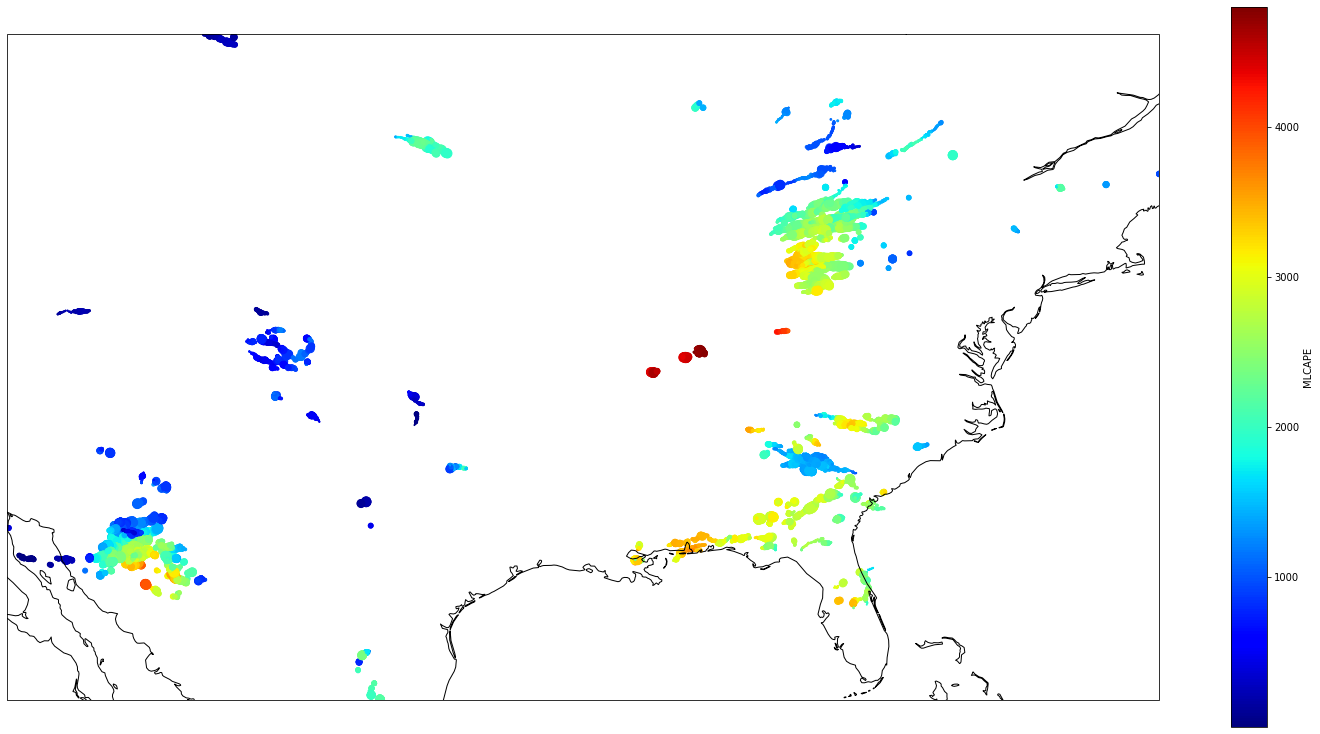

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111, aspect="equal", projection=ccrs.PlateCarree())
ax.set_extent(
    [
        *df["x"].agg(["min", "max"]),
        *df["y"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)
ax.coastlines("50m")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

df.plot.scatter(
    x="x",
    y="y",
    c="MLCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax,
)

In [7]:
def prepare_data(df: pd.DataFrame, min_probsevere: int = 20) -> pd.DataFrame:
    mask = df["PS"].groupby("ID").max() > min_probsevere
    # index the dataframe with the storm id's where ps > 20
    df = df.loc[idx[:, mask[mask].index], :].copy()
    x1, y1 = np.array(
        tuple((Polygon(list(arr)).centroid.xy for arr in df["geometry"])),
        dtype=np.float32,
    ).T[0]
    # create 2 arrays to represent our grid space
    x2 = np.linspace(
        -129.995,
        -60.005002000040975,
        7000,
        dtype=np.float32,
    )
    y2 = np.linspace(
        54.995,
        20.005000000002696,
        2500,
        dtype=np.float32,
    )
    # # create a common axis with [:,np.newaxis] subtract the arrays, index the gridspace with the index position
    df.loc[:, "x"] = x2[np.argmin(abs(x1 - x2[:, np.newaxis]), axis=0)]
    df.loc[:, "y"] = y2[np.argmin(abs(y1 - y2[:, np.newaxis]), axis=0)]
    return df.drop(
        columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],
    ).loc[df.index.unique("validTime"), :]


df = load_parquet(PARQUET_FILE).pipe(prepare_data)
# bool values of where the max PS for a storm was less that 20
df

NameError: name 'load_parquet' is not defined

In [ ]:
ps_100_2022 = df_2022.loc[df_2022["PS"] == PROB_SEVERE].index.unique("ID")
ps_100_2022

Index(['357877', '358776', '358782', '358768', '365855', '364627', '357279',
       '366243', '366548', '368355', '367657', '368722', '367316', '369187',
       '359420', '359169', '358192'],
      dtype='object', name='ID')

In [ ]:
def x_and_y(df: pd.DataFrame, grid: GridSpace) -> pd.DataFrame:
    """calculate geometric center of storm and fit the stom to the gridspace"""

    def generate():
        for arr in df["geometry"]:
            point = Polygon(arr.tolist()).centroid
            yield point.x, point.y

    x, y = np.array(tuple(generate()), dtype=np.float32).T
    # index position of nearest grid
    df["X"] = np.argmin(abs(x[:, np.newaxis] - grid.x), axis=1)
    df["Y"] = np.argmin(abs(y[:, np.newaxis] - grid.y), axis=1)
    # TODO: compute the aprox grid step based on ME and MS

    return df


gdf_2021 = df_2021.pipe(x_and_y, grid).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)
gdf_2022 = df_2022.pipe(x_and_y, grid).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)

In [ ]:
gdf_2022.shape, gdf_2021.shape
assert (gdf_2021.dtypes == gdf_2022.dtypes).all()

In [ ]:
# unique storms with a 100% ProbSevere
_2021 = gdf_2021.loc[idx[:, ps_100_2021], :]
_2022 = gdf_2022.loc[idx[:, ps_100_2022], :]

In [ ]:
columns = [
    "PS",
    "X",
    "Y",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MLCIN",
    "MUCAPE",
    "MLCAPE",
    "MESH",
    "VIL_DENSITY",
]


def embed(df: pd.DataFrame) -> pd.DataFrame:
    # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
    # Principal component analysis (PCA).
    pca = PCA(n_components=1, svd_solver="arpack")
    df["CAPE"] = pca.fit_transform(
        df[
            [
                "MLCIN",
                "MUCAPE",
                "MLCAPE",
            ]
        ]
    )

    return df[
        ["PS", "X", "Y", "MOTION_EAST", "MOTION_SOUTH", "CAPE", "MUCAPE", "MLCAPE"]
    ]


def resize_ps(df: pd.DataFrame) -> pd.DataFrame:
    df["PS"] = df["PS"] * (df["PS"] * 0.010)
    return df

<AxesSubplot:xlabel='X', ylabel='Y'>

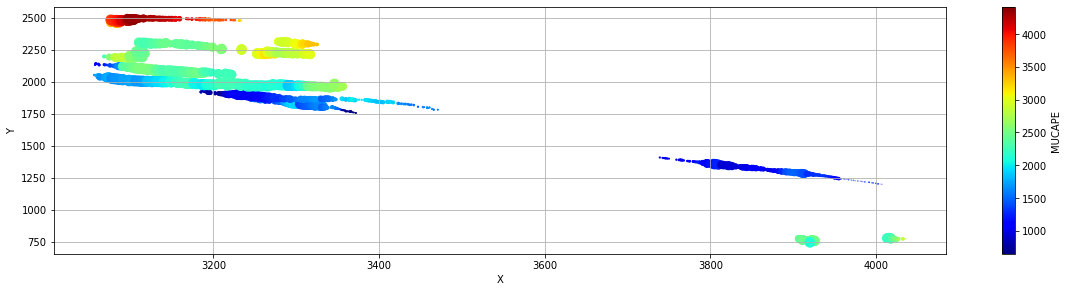

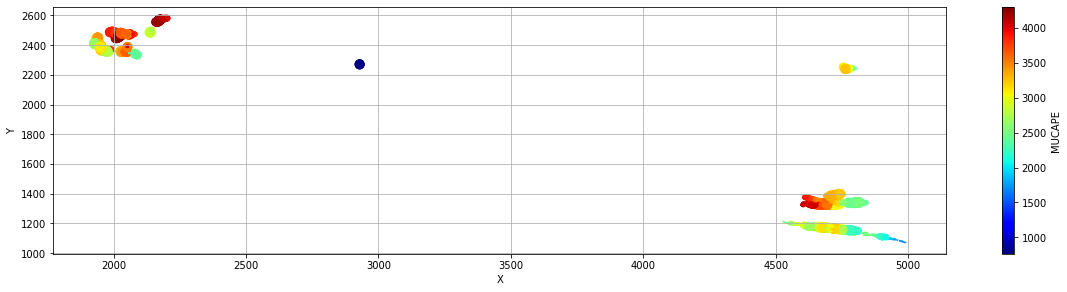

In [ ]:
import cartopy.crs as ccrs

plt.rcParams["axes.grid"] = True
#
plt.figure(1)
ax1 = plt.subplot(211)
_2021.copy()[columns].pipe(embed).pipe(resize_ps).plot.scatter(
    x="X",
    y="Y",
    c="MUCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax1,
    figsize=(20, 10),
)
plt.figure(2)
ax2 = plt.subplot(211)
_2022.copy()[columns].pipe(embed).pipe(resize_ps).plot.scatter(
    x="X",
    y="Y",
    c="MUCAPE",
    s="PS",
    cmap=plt.get_cmap("jet"),
    ax=ax2,
    # ax=axs[0, 1],
    figsize=(20, 10),
)

In [ ]:
import functools
from gym.spaces import Discrete
from pettingzoo import ParallelEnv
from pettingzoo.utils import wrappers
from pettingzoo.utils import parallel_to_aec

#                 "MOTION_EAST": "1.233", "MOTION_SOUTH": "-0.212",
EAST = 1
SOUTH = 1
NORTH = -1
WEST = -1
# ROCK = 0
# PAPER = 1
# SCISSORS = 2
# NONE = 3
MOVES = ["ROCK", "PAPER", "SCISSORS", "None"]
NUM_ITERS = 100
REWARD_MAP = {
    # (ROCK, ROCK): (0, 0),
    # (ROCK, PAPER): (-1, 1),
    # (ROCK, SCISSORS): (1, -1),
    # (PAPER, ROCK): (1, -1),
    # (PAPER, PAPER): (0, 0),
    # (PAPER, SCISSORS): (-1, 1),
    # (SCISSORS, ROCK): (-1, 1),
    # (SCISSORS, PAPER): (1, -1),
    # (SCISSORS, SCISSORS): (0, 0),
}


def env():
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    env = raw_env()
    # This wrapper is only for environments which print results to the terminal
    env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
    env = wrappers.AssertOutOfBoundsWrapper(env)
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


def raw_env():
    """
    To support the AEC API, the raw_env() function just uses the from_parallel
    function to convert from a ParallelEnv to an AEC env
    """
    env = parallel_env()
    env = parallel_to_aec(env)
    return env


class parallel_env(ParallelEnv):
    metadata = {"render_modes": ["human"], "name": "rps_v2"}

    def __init__(self):
        """
        The init method takes in environment arguments and should define the following attributes:
        - possible_agents
        - action_spaces
        - observation_spaces

        These attributes should not be changed after initialization.
        """
        self.possible_agents = ["player_" + str(r) for r in range(2)]
        self.agent_name_mapping = dict(
            zip(self.possible_agents, list(range(len(self.possible_agents))))
        )

    # this cache ensures that same space object is returned for the same agent
    # allows action space seeding to work as expected
    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        # Gym spaces are defined and documented here: https://gym.openai.com/docs/#spaces
        return Discrete(4)

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return Discrete(3)

    def render(self, mode="human"):
        """
        Renders the environment. In human mode, it can print to terminal, open
        up a graphical window, or open up some other display that a human can see and understand.
        """
        if len(self.agents) == 2:
            string = "Current state: Agent1: {} , Agent2: {}".format(
                MOVES[self.state[self.agents[0]]], MOVES[self.state[self.agents[1]]]
            )
        else:
            string = "Game over"
        print(string)

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass

    def reset(self, seed=None):
        """
        Reset needs to initialize the `agents` attribute and must set up the
        environment so that render(), and step() can be called without issues.

        Here it initializes the `num_moves` variable which counts the number of
        hands that are played.

        Returns the observations for each agent
        """
        self.agents = self.possible_agents[:]
        self.num_moves = 0
        observations = {agent: None for agent in self.agents}
        return observations

    def step(self, actions):
        """
        step(action) takes in an action for each agent and should return the
        - observations
        - rewards
        - dones
        - infos
        dicts where each dict looks like {agent_1: item_1, agent_2: item_2}
        """
        # If a user passes in actions with no agents, then just return empty observations, etc.
        if not actions:
            self.agents = []
            return {}, {}, {}, {}

        # rewards for all agents are placed in the rewards dictionary to be returned
        rewards = {}
        rewards[self.agents[0]], rewards[self.agents[1]] = REWARD_MAP[
            (actions[self.agents[0]], actions[self.agents[1]])
        ]

        self.num_moves += 1
        env_done = self.num_moves >= NUM_ITERS
        dones = {agent: env_done for agent in self.agents}

        # current observation is just the other player's most recent action
        observations = {
            self.agents[i]: int(actions[self.agents[1 - i]])
            for i in range(len(self.agents))
        }

        # typically there won't be any information in the infos, but there must
        # still be an entry for each agent
        infos = {agent: {} for agent in self.agents}

        if env_done:
            self.agents = []

        return observations, rewards, dones, infos


# grid.reward_matrix(-127, 50)
# len(grid.x)
grid.x, grid.y

In [ ]:
# https://www.pettingzoo.ml/sisl/pursuit

len(grid.x)

In [ ]:
# import gym
# import tensorflow as tf
from pettingzoo.sisl import pursuit_v4
from pettingzoo.butterfly import pistonball_v6

from sppp.transfer.funcs import mask_frames_by_id
from sppp.transfer.const import GridSpace

# env = pistonball_v6.env()
zeros = grid.zeros_grid()


class SPPPEnv(gym.Env):
    def __init__(self, state: "State") -> None:
        self.state = state

    def _compute_reward(self) -> int:
        return 1

    def step(self, action: np.ndarray):
        # action is produced by DQN, action is discrete
        # self.cache.move(action)
        # compute reward based on state(position) of the car
        # storm_state = self.car_agent.getCarState()
        # reward = self._compute_reward(storm_state)
        # # check if the episode is done
        # car_controls = self.car_agent.getCarControls()
        # done = self._isDone(storm_state, car_controls, reward)
        # # log info
        # info = {}
        # # observation is RGB image from car's camera
        # observation = self.car_agent.observe()
        observation = self.state.latests
        reward = self._compute_reward()
        done = False
        info = {}
        return observation, reward, done, info

    @property
    def observation_space(self) -> pd.DataFrame:
        return self.state.latests


def iterframe(df: pd.DataFrame) -> Iterable[tuple[pd.Timestamp, pd.DataFrame]]:
    yield from df.groupby("validTime")


n_inputs = 4
state = State()
env = SPPPEnv(state)
loss = keras.losses.binary_crossentropy
reward_map = make_reward_map()


n_outputs = 5
box_shape = 5


def reward_matrix(x: int, y: int, box_size: int = 5):
    gamefield = (
        zeros.loc[
            y - box_size : y + box_size,
            x - box_size : x + box_size,
        ].copy()
        + reward_map
    )
    return gamefield.values


transition_probs = [[0, 0, 1] * 20] * 101
possible_actions = [[0, 1, 2], [0, 2], [1]] * 101  # [list(range(-5, 5))] * 101


def swp_class_ploicy(
    state: int,  # probiblity of severe weather
    epsilon=0,
):
    if np.random.rand() < epsilon:
        return np.random.randint()
    # v = model.predict(state[np.newaxis])
    return np.random.choice(possible_actions[state])


class SevereWeatherClassifcation:
    def policy(self, series: pd.Series) -> np.ndarray:
        return 1


swc = SevereWeatherClassifcation()

if __name__ == "__main__":
    for vt, df in iterframe(midf.loc[idx[:, "89519"], :]):
        track_rewards = 0
        obs = env.reset()
        # evaluate prediction
        if state.has_hist():
            # there is existing storm information normalize frame_a and frame_b by the the in's in the index
            frame_a, frame_b = mask_frames_by_id(state.latests, df)
            # assert that the frames are of an equal shape
            assert frame_a.shape == frame_b.shape
            # bg = frame_b[["MOTION_EAST", "MOTION_SOUTH", "STAB"]].values
            # x = play_one_step(env, bg, model, loss)
            # obs, reward, done, info = env.step(frame_b[["MOTION_EAST", "MOTION_SOUTH"]])
            with tf.GradientTape() as tape:
                for x, s in frame_b.iterrows():
                    model = build_model(s)
                    reward = grid.reward_matrix(s.X, s.Y)
                    action = swc.policy(s)
        state.set_storm(df)

reward

In [ ]:
reward.stack().plot()